In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from google.colab import userdata
import os

In [ ]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d ryanholbrook/fe-course-data

Dataset URL: https://www.kaggle.com/datasets/ryanholbrook/fe-course-data
License(s): copyright-authors
 70% 18.0M/25.8M [00:00<00:00, 95.6MB/s]
100% 25.8M/25.8M [00:00<00:00, 112MB/s] 


In [ ]:
!mkdir "/content/Dataset"

In [ ]:
!unzip "/content/fe-course-data.zip" -d "/content/Dataset"

Archive:  /content/fe-course-data.zip
  inflating: /content/Dataset/DataDocumentation.txt  
  inflating: /content/Dataset/abalone.csv  
  inflating: /content/Dataset/accidents.csv  
  inflating: /content/Dataset/airbnb.csv  
  inflating: /content/Dataset/ames.csv  
  inflating: /content/Dataset/autos.csv  
  inflating: /content/Dataset/bike-sharing.csv  
  inflating: /content/Dataset/caravan.csv  
  inflating: /content/Dataset/concrete.csv  
  inflating: /content/Dataset/customer.csv  
  inflating: /content/Dataset/housing.csv  
  inflating: /content/Dataset/movielens1m.csv  
  inflating: /content/Dataset/spotify.csv  


In [ ]:
df = pd.read_csv("/content/Dataset/concrete.csv")

In [ ]:
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Certainly, I'd be happy to explain these concepts.

1. 5-fold cross-validation:

Cross-validation is a resampling technique used to evaluate machine learning models on a limited data sample. The "5-fold" part means the data is divided into 5 equal parts or "folds".

Here's how 5-fold cross-validation works:

1. The dataset is divided into 5 equal parts.
2. The model is trained on 4 parts and tested on the 1 remaining part.
3. This process is repeated 5 times, each time using a different part as the test set.
4. The model's performance is then averaged across all 5 iterations.

This method helps to prevent overfitting and gives a more robust estimate of the model's performance on unseen data.

2. neg_mean_absolute_error:

Mean Absolute Error (MAE) is a common metric used to evaluate regression models. It measures the average magnitude of errors in a set of predictions, without considering their direction.

The "neg" in "neg_mean_absolute_error" stands for "negative". In scikit-learn, scoring functions are defined so that higher values are better. However, for error metrics like MAE, lower values are actually better. To align with the convention that higher is better, scikit-learn returns the negative of the error. ( There's no strict rule that you must use "neg_mean_absolute_error" specifically.)

So, when you use "neg_mean_absolute_error" as your scoring metric:

1. It calculates the Mean Absolute Error.
2. It returns the negative of this value.

This is why in the code, after calculating the cross-validation score, it's multiplied by -1 to get back to the actual (positive) MAE value:

```python
baseline_score = -1 * baseline_score.mean()
```

This conversion allows for consistent comparison across different scoring metrics in scikit-learn, where higher values always indicate better performance.

In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")
model = RandomForestRegressor(criterion="absolute_error", random_state=0) # create a RandomForestRegressor model
model_score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
model_score = -1 * model_score.mean()
print(f"MAE Baseline Score: {model_score:.4}")

MAE Baseline Score: 8.232


In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


## Mutual Information


Usually Higher MI score means that feature is more useful.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/Dataset/autos.csv")

We can calculate Mutual Information (MI) scores for all features using either mutual_info_classification or mutual_info_regression, depending on whether the target variable is categorical or continuous, respectively. However, before calculating MI scores, it's crucial to ensure that all features are represented numerically. So as u can see below features dtype gotta be either between int64 or float64.

In [ ]:
X = df.copy()
y = X.pop("price")

for colname in X.select_dtypes("object"):
  X[colname], _ = X[colname].factorize() # factorize() method is a pandas function that encodes categorical data into numerical form


# All discrete features should now have integer dtypes (double check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
X.dtypes

symboling              int64
make                   int64
fuel_type              int64
aspiration             int64
num_of_doors           int64
body_style             int64
drive_wheels           int64
engine_location        int64
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type            int64
num_of_cylinders       int64
engine_size            int64
fuel_system            int64
bore                 float64
stroke               float64
compression_ratio      int64
horsepower             int64
peak_rpm               int64
city_mpg               int64
highway_mpg            int64
dtype: object

With the data properly prepared, we can now calculate the MI scores for all features. When using mutual_info_regression, we specify which features are discrete through the discrete_features parameter. It's important to note that this function calculates MI scores for both discrete and continuous features; we're simply informing it about the nature of each feature to ensure appropriate calculation methods are used

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
  # here we' just saying what are discrete features, it calculates mi score for all feautes(discrete and continuous)
  # if target feature is discrete then use mutual_info_classification
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores


mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

curb_weight          1.543240
highway_mpg          0.949524
length               0.610758
bore                 0.491827
stroke               0.389896
num_of_cylinders     0.332501
compression_ratio    0.134677
fuel_type            0.047298
Name: MI Scores, dtype: float64

and then we can plot the mi scores.

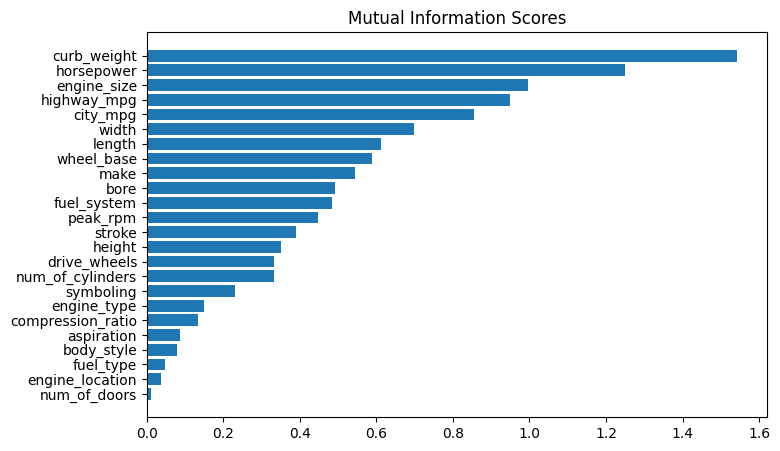

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)


    plt.barh(width, scores) # draw horizontal bar chart
    plt.yticks(width, ticks) # set the index name
    plt.title("Mutual Information Scores")


# here dpi stands for 'dot per inch'
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

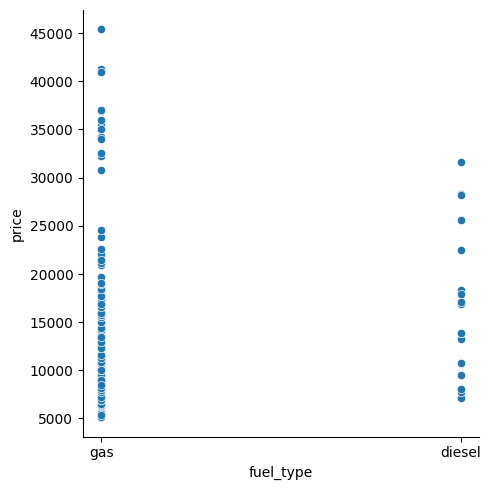

In [ ]:
sns.relplot(x='fuel_type', y='price', data=df)

The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates two price populations with different trends within the horsepower feature. This indicates that fuel_type contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.



### Mathematical Transforms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Simple 1

In [ ]:
df['stroke_ratio'] = df.stroke/df.bore
df[['stroke', 'bore', 'stroke_ratio']].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


Simple 2

In [ ]:
df['displacement'] = (np.pi * ((0.5 * df.bore) ** 2) * df.stroke * df.num_of_cylinders)

Simple 3: Handle Skwed Column; Change distribution of data

In [ ]:
accidents = pd.read_csv("/content/Dataset/accidents.csv")

<ipython-input-21-a7b44e7eed2d>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
<ipython-input-21-a7b44e7eed2d>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1])


<Axes: xlabel='LogWindSpeed', ylabel='Density'>

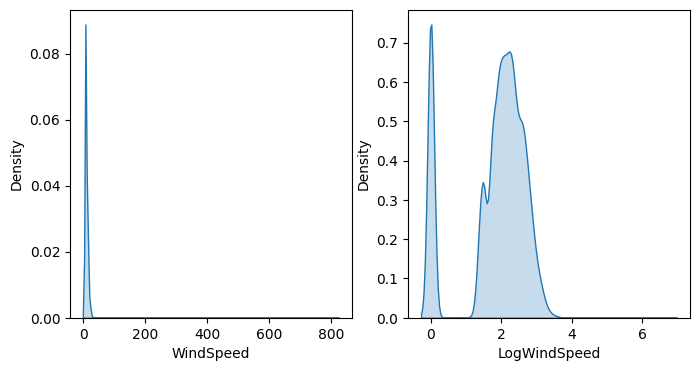

In [ ]:
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# plot a comparsion
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1])

### Count


example 1

In [ ]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

In [ ]:
accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


example2

In [ ]:
concrete = pd.read_csv("/content/Dataset/concrete.csv")

In [ ]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]

In [ ]:
concrete["Components"] = concrete[components].gt(0).sum(axis=1)
concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


### Building-Up and Breaking-Down Features


In [ ]:
customer = pd.read_csv("/content/Dataset/customer.csv")

Breaking up Features

In [ ]:
customer[["Type", "Level"]] = customer['Policy'].str.split(" ", expand=True)
customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


Joining Features

In [ ]:
autos = pd.read_csv("/content/Dataset/autos.csv")

In [ ]:
autos['make_and_style'] = autos['make'] + "_" + autos['body_style']
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


### Group TransForms

Example 1

Here transform() gets mean of Income column for each sub DataFrames. So for exmaple, if there were 50 subgroups, it's getting 50 values. Then it put those values back to each all corresponding roes

In [ ]:
customer["AverageIncome"] = customer.groupby('State')['Income'].transform('mean')
customer[['State', 'Income', 'AverageIncome']].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


Exmaple2

In [ ]:
customer['StateFreq'] = customer.groupby('State')['State'].transform('count')/customer.State.count()
customer[['State', 'StateFreq']].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


Example 3



If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's merge method after creating a unique set of values with drop_duplicates on the training set:

"By applying drop_duplicates() to the df_train[["Coverage", "AverageClaim"]], we create a reference table with one row per unique Coverage type. This table has fewer rows than both the original training set and the validation set.
When we merge this reference table with the validation set using on="Coverage", we're essentially performing a lookup operation:

For each row in the validation set, the merge operation looks at the 'Coverage' value.
It then finds the matching 'Coverage' in the reference table (the result of drop_duplicates()).
The corresponding 'AverageClaim' value from the reference table is added to the validation set row.

This process ensures that:

Each row in the validation set gets the correct 'AverageClaim' value based on its 'Coverage'.
The number of rows in the validation set remains unchanged.
We avoid duplicating data or creating unnecessary rows.

The how='left' parameter in the merge function guarantees that all rows from the validation set are kept, even if a matching 'Coverage' is not found in the reference table (which shouldn't happen if the validation set only contains 'Coverage' types seen in the training set).
This method is both memory-efficient (as we're not duplicating the entire training set) and computationally efficient (as we're merging with a much smaller reference table). It's a common and effective technique in feature engineering when working with train-validation splits, ensuring that we use information only from the training set to create features for the validation set, thus preventing data leakage."

In [ ]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Basic,378.201132
1,Extended,480.043703
2,Basic,378.201132
3,Premium,642.787231
4,Basic,378.201132
5,Extended,480.043703
6,Premium,642.787231
7,Basic,378.201132
8,Basic,378.201132
9,Basic,378.201132


Certainly! I'll break down each point and explain it in simpler terms:

1. Linear models and simple math:
   Linear models (like linear regression) are good at understanding straightforward addition and subtraction relationships between features. However, they struggle with more complex relationships. For example, they can easily understand that "height + weight" affects something, but they can't naturally figure out that "height * weight" might be important.

2. The power of ratios:
   Most models, including linear and tree-based ones, find it hard to automatically discover that the ratio between two features is important. For example, a model might struggle to figure out on its own that "income / debt" is a crucial factor. By creating these ratio features ourselves, we often see quick improvements in model performance.

3. Feature scaling for different models:
   - Linear models and neural networks work better when all features are on a similar scale (like between 0 and 1). This is called normalization.
   - Neural networks especially need features to be close to 0 because of how they process information internally.
   - Tree-based models (like Random Forests) don't usually need normalized features because they make decisions by comparing values, not by their absolute scale. However, normalizing can sometimes still help these models, just not as much.

4. Explicit feature combinations for tree models:
   Tree models can theoretically figure out complex relationships between features by making many splits. However, when we know a specific combination of features is important, it's often helpful to create that combination explicitly. This is especially true when we don't have a lot of data. For example, if we know "age * income" is important, creating this as a new feature can help the model learn faster and with less data.

5. Count features for tree models:
   Tree models make decisions by splitting data based on feature values. They're not naturally good at adding up information from many features at once. Count features (like "number of times a customer bought something") provide a pre-summarized view of multiple data points, which can be very helpful for tree models.

In essence, these tips are about understanding the strengths and limitations of different types of models, and then creating features that play to those strengths or compensate for those limitations. By doing so, we can often improve model performance significantly.

## Clustering

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv('/content/Dataset/housing.csv')
X = df.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [ ]:
# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,4
1,8.3014,37.86,-122.22,4
2,7.2574,37.85,-122.24,4
3,5.6431,37.85,-122.25,4
4,3.8462,37.85,-122.25,0


In [ ]:
X.Cluster.dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5], ordered=False)

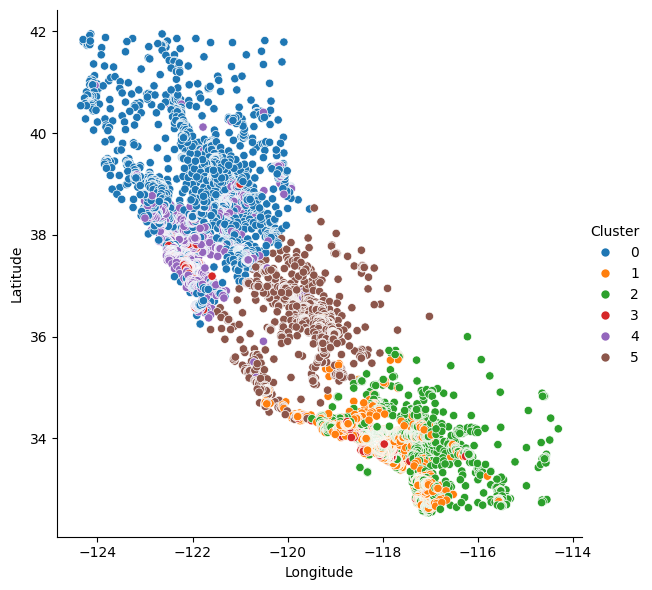

In [ ]:
sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

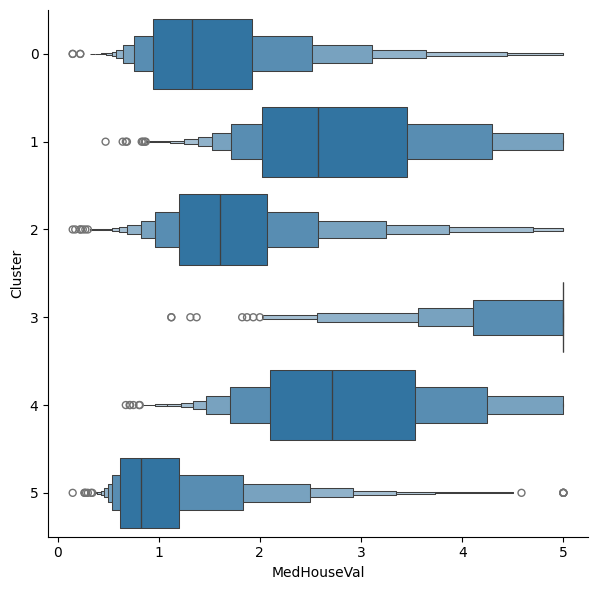

In [ ]:
X["MedHouseVal"] = df["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

## PCA(Principal Component Analysis)


Certainly, I'll review the content for any errors and provide an improved version:

**PCA**

PCA (Principal Component Analysis) is a technique to create new features by transforming existing features. While K-means clustering divides data points into groups, PCA divides the variation of data into orthogonal components.

If we have 2 features, after applying PCA, we will have exactly 2 components; with three features, we'll get three components. Before applying PCA, it's often recommended to standardize the data, although this isn't always necessary depending on the nature of your data.

You can use PCA in these ways:

1. New Feature discovery
After applying PCA, you can analyze the components to gain insights. For example, if we have four PCA components derived from four original features, we can calculate the importance (e.g., explained variance ratio) of each component. If we find that a component capturing the relationship between column1 and column2 explains the most variance, we might consider creating a new feature that combines these columns, such as their product or ratio.

(Note: It's important to understand that high variance in a component doesn't necessarily correlate with high mutual information (MI) score with respect to a target variable.)

2. Using PCA components as features
* **Dimensionality reduction**: When your features are highly redundant (specifically, multicollinear), PCA can partition out this redundancy into one or more low-variance components. These can often be dropped without significant loss of information, reducing the dimensionality of your dataset.
* **Anomaly detection**: Unusual variations that aren't apparent in the original features often show up in the low-variance components. These components can be highly informative for anomaly or outlier detection tasks.
* **Noise reduction**: In datasets like sensor readings with common background noise, PCA can sometimes separate the informative signal into a smaller number of high-variance components while isolating noise in low-variance components. This can effectively boost the signal-to-noise ratio.
* **Decorrelation**: Some ML algorithms perform poorly with highly-correlated features. PCA transforms correlated features into uncorrelated components, which can be easier for certain algorithms to work with.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("/content/Dataset/autos.csv")

<ipython-input-40-218d03804a7a>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Standardize Features

In [ ]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

Create PCA Components

In [ ]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()


,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


Component's loadings tell us what variation it expresses through signs and magnitudes:



In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Look at explained variance

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

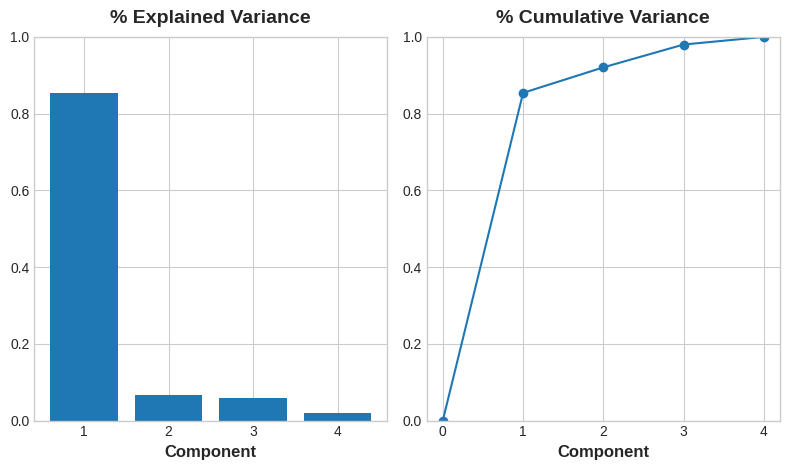

In [ ]:
plot_variance(pca)

## Target Encoding

MI - works on both discrete and continous features

kmenas and pca onlyu works with numerical feaures

target encoding - wokrs on cateogircal features, more specificlay its replcaing cateogircal features with numerical features

Exampl1

Make make_encoded(numerical) features using make(categorical features)

However, this kind of target encoding can causs some problems.

1. unkown categories:

Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.


2. rare categoires:

When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. In the Automobiles dataset, the mercurcy make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.



A solution to these problems is to add smoothing. Idea here is rare category  get less weight


`encoding = weight * in_category + (1 - weight) * overall`


`weight = n / (n + m)`

where n is the total number of times that category occurs in the data. The parameter m determines the "smoothing factor". Larger values of m put more weight on the overall estimate.

In the Automobiles dataset there are three cars with the make chevrolet. If you chose m=2.0, then the chevrolet category would be encoded with 60% of the average Chevrolet price plus 40% of the overall average price.


`chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03`

here if price of vehicles vary alot depending on maker, the using bigger m. otherwise smaller m would be fine




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("/content/Dataset/movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

<ipython-input-45-e864adfa84fe>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Number of Unique Zipcodes: 3439


In [ ]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_pretrain = y[X_pretrain.index]

In [ ]:
!pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 987.9 kB/s eta 0:00:00


We divid the dataset into 25% and 75%. then using 25% we get in_category and overall. Then when we do target encoding, we use those values we got from 25%.

In [ ]:
from category_encoders import MEstimateEncoder

encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)
encoder.fit(X_encode, y_encode) # here we're getting in_category and overall.
# here we pass y_encode to because we're getting mean of cateogory for values of ratings(y)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Now you can see the catrofical features Zipcode now tunred into Numerical Features

In [ ]:
X_train.Zipcode

0          3.799238
2          3.521011
3          3.615324
4          3.892756
5          3.284735
             ...   
1000203    3.414601
1000204    3.210042
1000205    3.792404
1000207    3.785202
1000208    3.336845
Name: Zipcode, Length: 750157, dtype: float64

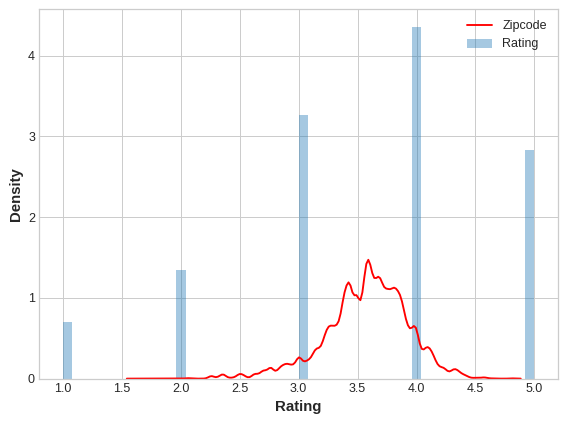

In [ ]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating'])